In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/final-fakenews-dataset/final.csv


In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/



Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [4]:
df=pd.read_csv("/kaggle/input/final-fakenews-dataset/final.csv")

In [5]:
df.head()


,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0


In [6]:
df.shape

(68363, 3)

In [7]:
df.columns

Index(['title', 'text', 'label'], dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68363 entries, 0 to 68362
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   68115 non-null  object
 1   text    44919 non-null  object
 2   label   68363 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [9]:
df.isnull().sum()

title      248
text     23444
label        0
dtype: int64

In [10]:
df[df['title'].isnull() & (df['text'].isnull())]

,title,text,label
9732,NaN,NaN,0
12409,NaN,NaN,0
13365,NaN,NaN,0
17856,NaN,NaN,0
19630,NaN,NaN,0
...,...,...,...
46860,NaN,NaN,1
46880,NaN,NaN,1
46890,NaN,NaN,1
46914,NaN,NaN,1


In [11]:
df=df.dropna(subset=['title'])

In [12]:
df.isnull().sum()

title        0
text     23196
label        0
dtype: int64

In [13]:
df.shape

(68115, 3)

In [14]:
df.duplicated().sum()

7152

In [15]:
df=df.drop_duplicates()

In [16]:
df.shape

(60963, 3)

In [17]:
df['label'].value_counts()

label
1    37721
0    23242
Name: count, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


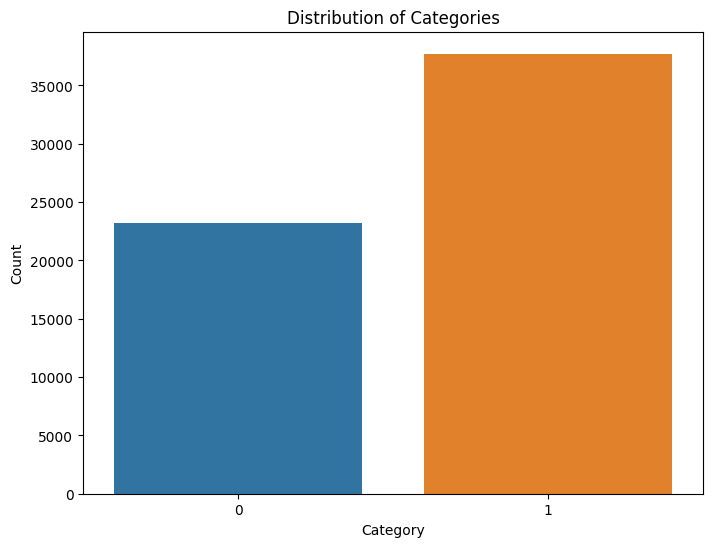

In [18]:
# Visualize distribution of categories
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [19]:
# Convert NaN values to empty strings and non-string elements to strings
df['title'] = df['title'].astype(str)
df['text'] = df['text'].astype(str)

# Calculate text length
df['Title_Length'] = df['title'].apply(len)
df['Article_Length'] = df['text'].apply(len)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


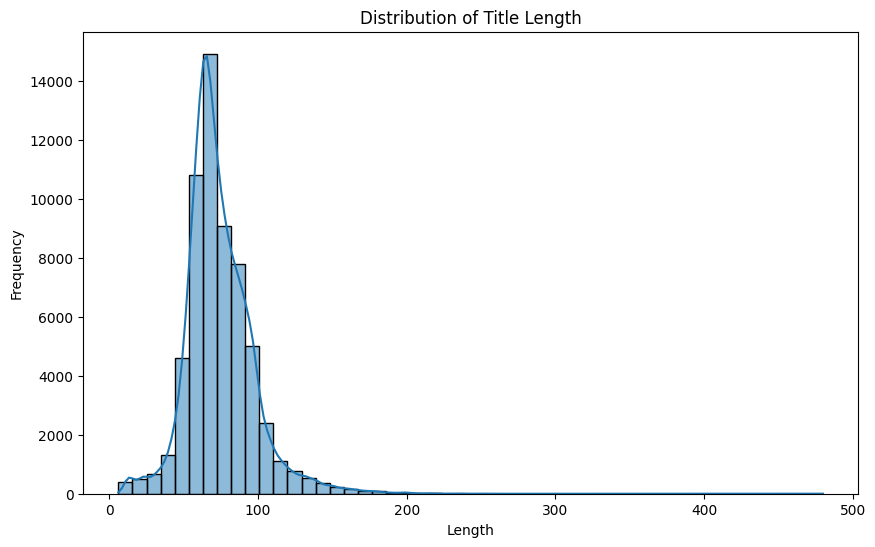

In [20]:
# Visualize text length distributions
plt.figure(figsize=(10, 6))
sns.histplot(df['Title_Length'], bins=50, kde=True)
plt.title('Distribution of Title Length')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


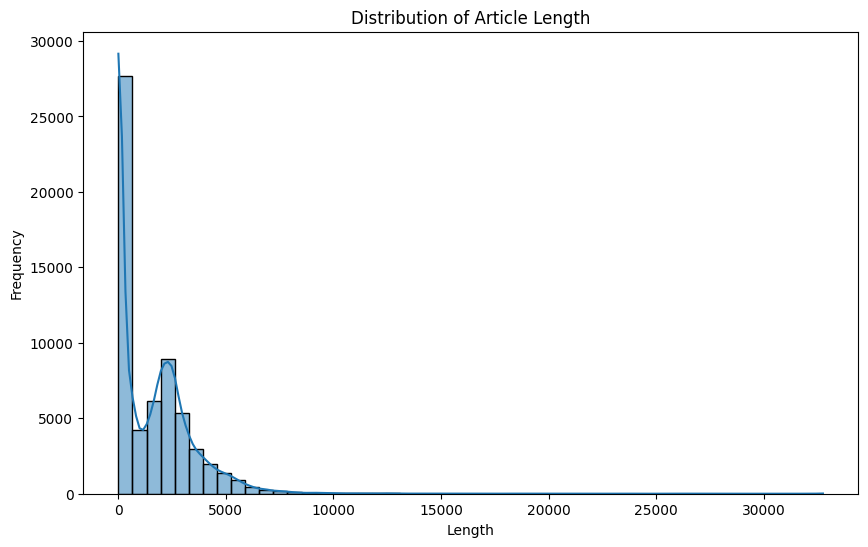

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Article_Length'], bins=50, kde=True)
plt.title('Distribution of Article Length')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [22]:
df['title']=df['title'].str.strip()
df['title'] = df['title'].str.replace('\n', '')
df['text']=df['text'].str.strip()
df['text'] = df['text'].str.replace('\n', '')

In [23]:
df['text'] = df['text'].fillna('')

In [24]:
df['Text']=df['title']+" "+df['text']
df['Text']

0        Donald Trump Sends Out Embarrassing New Year’s...
1        Drunk Bragging Trump Staffer Started Russian C...
2        Sheriff David Clarke Becomes An Internet Joke ...
3        Trump Is So Obsessed He Even Has Obama’s Name ...
4        Pope Francis Just Called Out Donald Trump Duri...
                               ...                        
68358    'Fully committed' NATO backs new U.S. approach...
68359    LexisNexis withdrew two products from Chinese ...
68360    Minsk cultural hub becomes haven from authorit...
68361    Vatican upbeat on possibility of Pope Francis ...
68362    Indonesia to buy $1.14 billion worth of Russia...
Name: Text, Length: 60963, dtype: object

In [25]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    filtered_words = [word for word in text.split() if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [26]:
special_chars_pattern = r'[^a-zA-Z0-9\s]'
def remove_special_chars(text):
    return re.sub(special_chars_pattern, '', text)

In [27]:
def remove_numbers(input_string):
    output_string = re.sub(r'\d+', '', input_string)
    return output_string

In [28]:
def convert_lower(text):
    return text.lower()

In [29]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

In [30]:
df['Text'] = df['Text'].apply(remove_stopwords)
df['Text'] = df['Text'].apply(remove_special_chars)
df['Text'] = df['Text'].apply(remove_numbers)
df['Text'] = df['Text'].apply(convert_lower)
df['Text'] = df['Text'].apply(lemmatize_words)


In [31]:
#declare dependent and independent value

x = df['Text']
y = df['label']

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [33]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)

# Transform the test data using the fitted vectorizer
x_test_tfidf = tfidf_vectorizer.transform(x_test)

In [34]:
# Tokenize and pad sequences (if intending to use sequence-based models)
max_words = 5000
max_len = 250
tokenizer = Tokenizer(num_words=max_words)
# Fit Tokenizer on training data
tokenizer.fit_on_texts(x_train)

In [35]:
# Convert text data to sequences and pad
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)
x_train_pad = pad_sequences(sequences_train, maxlen=max_len)
x_test_pad = pad_sequences(sequences_test, maxlen=max_len)

In [36]:
#Creating the lstm model
embedding_vector_features=128
model=Sequential()
model.add(Embedding(max_words,embedding_vector_features,input_length=max_len))
model.add(Dropout(0.3))
model.add(LSTM(100)) #Adding 100 lstm neurons in the layer
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

#Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 128)          640000    
                                                                 
 dropout (Dropout)           (None, 250, 128)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               91600     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 731701 (2.79 MB)
Trainable params: 731701 (2.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [37]:
model.fit(x_train_pad, y_train, epochs=10, batch_size=32, validation_data=(x_test_pad, y_test))


Epoch 1/10
1525/1525 [==============================] - 162s 102ms/step - loss: 0.2622 - accuracy: 0.8907 - val_loss: 0.2234 - val_accuracy: 0.9104
Epoch 2/10
1525/1525 [==============================] - 45s 30ms/step - loss: 0.2471 - accuracy: 0.9007 - val_loss: 0.2074 - val_accuracy: 0.9166
Epoch 3/10
1525/1525 [==============================] - 33s 22ms/step - loss: 0.1781 - accuracy: 0.9277 - val_loss: 0.1808 - val_accuracy: 0.9247
Epoch 4/10
1525/1525 [==============================] - 28s 18ms/step - loss: 0.1509 - accuracy: 0.9382 - val_loss: 0.1830 - val_accuracy: 0.9255
Epoch 5/10
1525/1525 [==============================] - 26s 17ms/step - loss: 0.1421 - accuracy: 0.9435 - val_loss: 0.1751 - val_accuracy: 0.9252
Epoch 6/10
1525/1525 [==============================] - 23s 15ms/step - loss: 0.1203 - accuracy: 0.9500 - val_loss: 0.2283 - val_accuracy: 0.9169
Epoch 7/10
1525/1525 [==============================] - 23s 15ms/step - loss: 0.1093 - accuracy: 0.9546 - val_loss: 0.2093

In [38]:
# Evaluate the model
y_pred = (model.predict(x_test_pad) > 0.5).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

382/382 [==============================] - 2s 4ms/step
Accuracy: 0.9217583859591569

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.90      4629
           1       0.93      0.95      0.94      7564

    accuracy                           0.92     12193
   macro avg       0.92      0.91      0.92     12193
weighted avg       0.92      0.92      0.92     12193


Confusion Matrix:
 [[4074  555]
 [ 399 7165]]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [39]:
# Creating bidirectional lstm model
embedding_vector_features=128
model1=Sequential()
model1.add(Embedding(max_words,embedding_vector_features,input_length=max_len))
model1.add(Bidirectional(LSTM(100))) # Bidirectional LSTM layer
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 128)          640000    
                                                                 
 bidirectional (Bidirection  (None, 200)               183200    
 al)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 823401 (3.14 MB)
Trainable params: 823401 (3.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [40]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [41]:
model.fit(x_train_pad, y_train, epochs=10, batch_size=32, validation_data=(x_test_pad, y_test))


Epoch 1/10
1525/1525 [==============================] - 115s 74ms/step - loss: 0.0723 - accuracy: 0.9705 - val_loss: 0.2656 - val_accuracy: 0.9170
Epoch 2/10
1525/1525 [==============================] - 37s 24ms/step - loss: 0.0637 - accuracy: 0.9738 - val_loss: 0.2815 - val_accuracy: 0.9105
Epoch 3/10
1525/1525 [==============================] - 29s 19ms/step - loss: 0.0557 - accuracy: 0.9776 - val_loss: 0.3121 - val_accuracy: 0.9136
Epoch 4/10
1525/1525 [==============================] - 24s 16ms/step - loss: 0.0508 - accuracy: 0.9793 - val_loss: 0.3269 - val_accuracy: 0.9157
Epoch 5/10
1525/1525 [==============================] - 24s 16ms/step - loss: 0.0456 - accuracy: 0.9810 - val_loss: 0.3353 - val_accuracy: 0.9108
Epoch 6/10
1525/1525 [==============================] - 22s 14ms/step - loss: 0.0430 - accuracy: 0.9826 - val_loss: 0.3872 - val_accuracy: 0.9117
Epoch 7/10
1525/1525 [==============================] - 20s 13ms/step - loss: 0.0399 - accuracy: 0.9833 - val_loss: 0.3888 

In [42]:
# Evaluate the model
y_pred = (model.predict(x_test_pad) > 0.5).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

382/382 [==============================] - 2s 5ms/step
Accuracy: 0.905355531862544

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87      4629
           1       0.92      0.93      0.92      7564

    accuracy                           0.91     12193
   macro avg       0.90      0.90      0.90     12193
weighted avg       0.91      0.91      0.91     12193


Confusion Matrix:
 [[4008  621]
 [ 533 7031]]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp